In [1]:
library(purrr)
library(magrittr)
library(tidyr)
library(tidytext)
library(dplyr)
library(stringr)
library(ggplot2)
library(tm)
library(topicmodels)
library(broom)

library(e1071)
library(caret)
library(randomForest)

Warning message:
"package 'purrr' was built under R version 3.5.2"Warning message:
"package 'magrittr' was built under R version 3.5.2"
Attaching package: 'magrittr'

The following object is masked from 'package:purrr':

    set_names

Warning message:
"package 'tidyr' was built under R version 3.5.2"
Attaching package: 'tidyr'

The following object is masked from 'package:magrittr':

    extract

Warning message:
"package 'tidytext' was built under R version 3.5.2"Warning message:
"package 'dplyr' was built under R version 3.5.2"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'stringr' was built under R version 3.5.2"Warning message:
"package 'ggplot2' was built under R version 3.5.2"Warning message:
"package 'tm' was built under R version 3.5.2"Loading required package: NLP
Warning message:
"package 'NLP' was b

In [2]:
reg <- "([^A-Za-z\\d#@']+|'[^A-Za-z\\d#@]+)"

df <- read.csv(
  "..\\..\\data\\Weekly_data_top_week.csv",
  encoding = "UTF-8",
  stringsAsFactors = FALSE)

df_words <- read.csv(
  "..\\..\\data\\Weekly_data_tokenized.csv", 
  encoding = "UTF-8",
  stringsAsFactors = FALSE)

unique_df_words <- read.csv(
  "..\\..\\data\\Weekly_data_tokenized_unique.csv", 
  encoding = "UTF-8",
  stringsAsFactors = FALSE)

metrics <- read.csv(
  "..\\..\\data\\Song_Complexity.csv",
  encoding = "UTF-8",
  stringsAsFactors = FALSE
)

df <- merge(x = df, y = metrics, by = c("X"), all.x = TRUE)
colnames(df)[colnames(df) == "Songwriter.x"] <- "Songwriter"

#final_df <- merge(x = max_week, y = df, by = c("Artists", "Name", "Weeks.on.chart"), all.x = TRUE)

unique_df_words <- unique_df_words %>%
    mutate(Pop = ifelse(str_detect(Genre, regex("pop", ignore_case = TRUE)), TRUE, FALSE)) %>%
    filter(str_detect(Genre, regex("rap|pop", ignore_case = TRUE)))

df_words <- df_words %>%
    mutate(Pop = ifelse(str_detect(Genre, regex("pop", ignore_case = TRUE)), TRUE, FALSE)) %>%
    filter(str_detect(Genre, regex("rap|pop", ignore_case = TRUE)))

df <- df %>%
    mutate(Pop = ifelse(str_detect(Genre, regex("pop", ignore_case = TRUE)), TRUE, FALSE)) %>%
    filter(str_detect(Genre, regex("rap|pop", ignore_case = TRUE)))

Warning message:
"package 'bindrcpp' was built under R version 3.5.2"

## Prediction

In [79]:
set.seed(0)
num_songs_present <- 5
num_words_to_filter <- 5

# one entry for each song-word
each_song <- unique_df_words %>%
    count(word, ID, Artists, Pop)

num_songs <- table(each_song$word)

good_words <- names(num_songs[num_songs >= num_songs_present])

word_count_matrix <- df_words %>%
  count(ID, word, sort = TRUE) %>%
  filter(word %in% good_words, n >= num_words_to_filter) %>%
  ungroup() %>% # do we need this?
  cast_dtm(ID, word, n)

indices <- sample(word_count_matrix$dimnames$Docs)

dtm.train <- word_count_matrix[indices[1:(nrow(word_count_matrix)*0.8)],]
dtm.test <- word_count_matrix[indices[(nrow(word_count_matrix)*0.8+1):nrow(word_count_matrix)],]

df.train <- df[df$ID %in% indices[1:(nrow(word_count_matrix)*0.8)], ]
df.test <- df[df$ID %in% indices[(nrow(word_count_matrix)*0.8+1):nrow(word_count_matrix)], ]
df.train.lab <- as.factor(df.train$Pop)
df.test.lab <- as.factor(df.test$Pop)

convert_count <- function(x) {
  y <- ifelse(x > 0, 1, 0)
  y <- factor(y, levels=c(0, 1), labels=c("No", "Yes"))
  y
}

trainNB <- apply(dtm.train, MARGIN = 2, convert_count)
testNB <- apply(dtm.test, MARGIN = 2, convert_count)

In [80]:
classifier <- naiveBayes(trainNB, df.train.lab, laplace = 0.3)
pred <- predict(classifier, testNB, type = "class")
conf.mat <- confusionMatrix(pred, df.test.lab)

conf.mat

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE    54   95
     TRUE    176  252
                                          
               Accuracy : 0.5303          
                 95% CI : (0.4887, 0.5717)
    No Information Rate : 0.6014          
    P-Value [Acc > NIR] : 0.9998          
                                          
                  Kappa : -0.0415         
 Mcnemar's Test P-Value : 1.176e-06       
                                          
            Sensitivity : 0.23478         
            Specificity : 0.72622         
         Pos Pred Value : 0.36242         
         Neg Pred Value : 0.58879         
             Prevalence : 0.39861         
         Detection Rate : 0.09359         
   Detection Prevalence : 0.25823         
      Balanced Accuracy : 0.48050         
                                          
       'Positive' Class : FALSE           
                                          

Just like in the Robotic vs. Non-robotic case, presence and absence of words do not seem to even be a good predictor of Genre. 

## Differences in sentiment

In [293]:
num_words_to_filter = 5

nrc <- sentiments %>%
    filter(lexicon == "nrc") %>%
    dplyr::select(word, sentiment)

sources <- unique_df_words %>%
    group_by(Pop) %>%
    mutate(total_words = n()) %>%
    ungroup() %>%
    distinct(Name, Pop, total_words)

by_source_sentiment <- unique_df_words %>%
    inner_join(nrc, by = "word") %>%
    count(sentiment, Name) %>%
    ungroup() %>%
    complete(sentiment, Name, fill = list(n = 0)) %>%
    inner_join(sources, "Name") %>%
    group_by(Pop, sentiment, total_words) %>%
    summarize(words = sum(n)) %>%
    ungroup()

sentiment_diff <- by_source_sentiment %>%
    group_by(sentiment) %>%
    do(tidy(poisson.test(.$words, .$total_words))) %>%
    ungroup() %>%
    mutate(sentiment = reorder(sentiment, estimate))

# plot
sentplot <- sentiment_diff  %>%
    ggplot(aes(sentiment, estimate)) + 
    geom_errorbar(width = .5, aes(ymin = conf.low, ymax = conf.high)) +
    geom_point(shape = 21, size = 2.5, fill = "white") +
    scale_y_continuous("",
                       limits = c(0.6, 1.2),
                       breaks = c(0.6, 0.8, 1, 1.2, 1.4, 1.6),
                       labels = c("-40%", "-20%", "0%", "20%", "40%", "60%")) +
    coord_flip() + 
    theme_bw() +
    ggtitle("% change in mean sentiment from Pop to Rap") + 
    theme(plot.title = element_text(hjust = -0.00, vjust = 3, size = 17))

ggsave("..//..//visualizations//rapvspopsentimentdiff.png",
       plot = sentplot,
       dpi = 800, width = 7 * 1.2, height = 5 * 1.2)

#ggsave(filename, plot = last_plot(), device = NULL, path = NULL,
#  scale = 1, width = NA, height = NA, units = c("in", "cm", "mm"),
#  dpi = 300, limitsize = TRUE, ...)

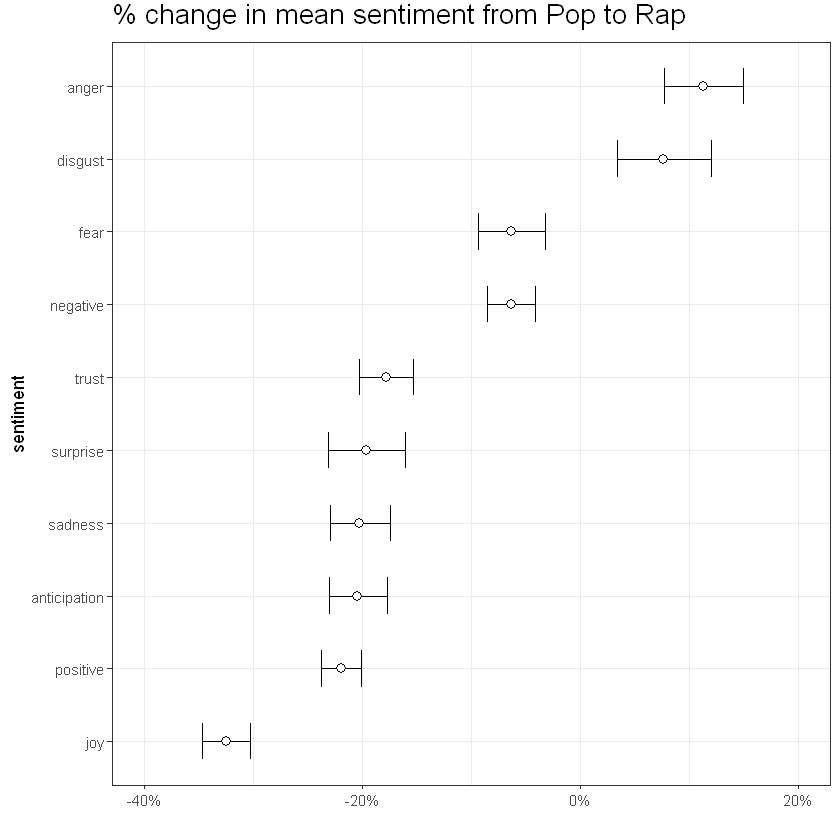

In [294]:
sentplot

Rap uses less words relating to joy, positivity, anticipation, sadness, surprise and trust than Pop music. On the other hand, Rap music uses more words relating to disgust and anger than pop music. Each result is significantly different than 0%.

## Differences in metrics - defined + metadata

In [71]:
df$Pop <- factor(df$Pop)
df$Songwriter <- factor(df$Songwriter)
first <- glm(Pop ~ 1,
             data = df,
             family = "binomial")
last <- glm(Pop ~ Peak.position + Weeks.on.chart + diversity + 
                  profanity_ratio + tf_idf_complexity + Songwriter +
                  mean_word_rarity + mean_word_length,
             data = df,
             family = "binomial")
#summary(last)

In [72]:
dim(df)

[1] 2983   30

In [73]:
selected <- step(last, 
                 #scope = list(lower = first, upper = last), 
                 directions = "backwards", 
                 k = log(2983))

Start:  AIC=3926.82
Pop ~ Peak.position + Weeks.on.chart + diversity + profanity_ratio + 
    tf_idf_complexity + Songwriter + mean_word_rarity + mean_word_length

                    Df Deviance    AIC
- mean_word_length   1   3854.8 3918.9
- diversity          1   3854.9 3918.9
- Weeks.on.chart     1   3855.6 3919.6
- mean_word_rarity   1   3855.6 3919.6
- tf_idf_complexity  1   3856.1 3920.1
- profanity_ratio    1   3856.4 3920.4
<none>                   3854.8 3926.8
- Peak.position      1   3868.1 3932.1
- Songwriter         1   3904.3 3968.3

Step:  AIC=3918.85
Pop ~ Peak.position + Weeks.on.chart + diversity + profanity_ratio + 
    tf_idf_complexity + Songwriter + mean_word_rarity

                    Df Deviance    AIC
- diversity          1   3854.9 3910.9
- Weeks.on.chart     1   3855.6 3911.6
- mean_word_rarity   1   3856.4 3912.4
- tf_idf_complexity  1   3856.4 3912.4
- profanity_ratio    1   3856.5 3912.5
<none>                   3854.8 3918.9
- Peak.position      1   386

In [77]:
tmp <- glm(Pop ~ Peak.position + Songwriter,
   data = df,
   family = "binomial")
summary(tmp)


Call:
glm(formula = Pop ~ Peak.position + Songwriter, family = "binomial", 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9169  -1.2744   0.8785   1.0262   1.1793  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     0.760786   0.076110   9.996  < 2e-16 ***
Peak.position  -0.007652   0.001241  -6.167 6.98e-10 ***
SongwriterTrue  0.910626   0.136765   6.658 2.77e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3969.0  on 2982  degrees of freedom
Residual deviance: 3863.1  on 2980  degrees of freedom
AIC: 3869.1

Number of Fisher Scoring iterations: 4


Findings:
- The lower your peak position, the more likely you are to be a rap song
- Pop songs are more likely than rap songs to include songwriters.

In [88]:
table(df$Pop, df$Songwriter)

       
        False True
  FALSE  1066   75
  TRUE   1539  303

Rows are Pop or not, columns are songwriter or not.

We can see that 19.688% of Pop songs included a songwriter but only 7.0356% of rap songs included a songwriter.

In [ ]:
df[df$Pop == TRUE, ]$Pop <- "Pop"
df[df$Pop == FALSE, ]$Pop <- "Rap"

In [295]:
peakplot <- ggplot(data = df, aes(x = Peak.position)) +
    geom_histogram(aes(fill=Pop), bins = 100, position = "identity", alpha = 0.4) +
    scale_fill_manual("Genre", values = c("steelblue1", "goldenrod")) +
    ggtitle("Distribution of Peak song positions") + 
    ylab("Number of songs") +
    xlab("Peak position") + 
    theme_bw() +
    theme(legend.justification = c(1, 1), 
          legend.position = c(0.99, 0.99),
    plot.title = element_text(hjust = -0.0, vjust = 3, size = 17))

ggsave("..//..//visualizations//peakposition.png",
       plot = peakplot,
       dpi = 800, width = 7 * 1.2, height = 5 * 1.2)

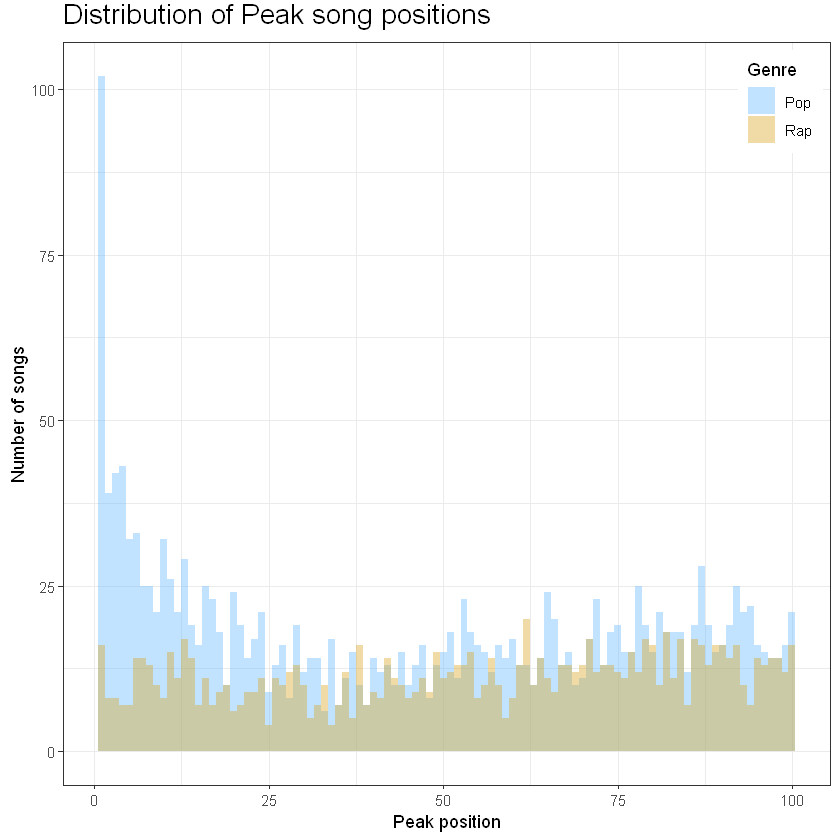

In [296]:
peakplot

This chart shows that pop songs tend to have a higher peak position than rap songs do.

## Bonus: LDA

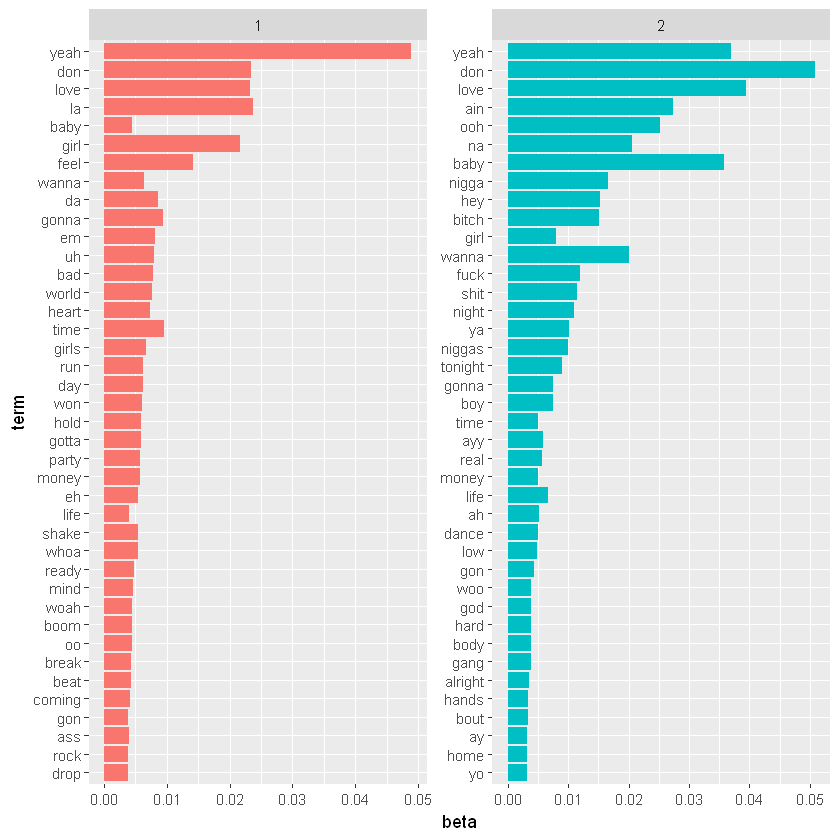

In [233]:
word_counts <- df_words %>%
    count(Name, word, sort = TRUE) %>%
    filter(n > num_words_to_filter) %>%
    ungroup() # do we need this?
    
word_count_matrix <- word_counts %>% cast_dtm(Name, word, n)

# create LDA object
songs_lda <- LDA(word_count_matrix, k = 2, control = list(seed = 0))
topics <- tidy(songs_lda, matrix = "beta")
    
# visualize
top_terms <- topics %>%
    group_by(topic) %>%
    top_n(40, beta) %>%
    ungroup() %>%
    arrange(topic, -beta)
    
top_terms %>%
    mutate(term = reorder(term, beta)) %>%
    ggplot(aes(term, beta, fill = factor(topic))) +
    geom_col(show.legend = FALSE) +
    facet_wrap(~ topic, scales = "free") + # partition by topic
    coord_flip()

Key takeaways:

- Words most likely to be generated from topic 1 include love, yeah, baby, wanna, la, and ooh. These seem to originate from pop songs.
- In contrast, words most likely to be generated from topic 2 include many expletives, particularly ones in rap songs. 

This leads us to believe LDA accurately captures a difference between the language used in pop songs and rap songs.
